# Import Functions

In [82]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from pathlib import Path
import numpy as np
#import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
#from dask_ml.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import pickle
import torch.autograd as autograd
import matplotlib.gridspec as gridspec
import os
import h5py
# from torchsummary import summary
# import pytorch_model_summary as pms
from tqdm import tqdm
#import torch.tensor as tensor
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import skimage
from skimage.feature import peak_local_max
from skimage import data, img_as_float,feature
from skimage import io
import cv2

In [83]:
torch.__version__

'1.11.0+cu102'

In [84]:
# # show the version of the package, just have a look and don't need to run this line.
# import session_info
# session_info.show()

# Loading Data

In [85]:
img = np.load('02_scan_x256_y256_raw.npy')

In [86]:
img = np.transpose(img,(2,3,0,1))

In [87]:
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r)
max_ = np.max(data_r)

#mn = np.mean(data_r.reshape(-1))
#sd = np.std(data_r.reshape(-1))
data_r = 1.0*(data_r-min_)/(max_-min_)

In [88]:
data_r = data_r.reshape(-1,1,124,124)

In [89]:
data_r_cut = data_r[:,:,2:122,2:122]

# Set Mask

In [90]:
# set inside boundary
image_1 = np.copy(data_r_cut[100].squeeze())
window_name = 'Image'
center_coordinates = (60, 60)
radius = 12
thickness = -1
color = 100
image_2 = cv2.circle(image_1, center_coordinates, radius,color, thickness)
image_2 = np.array(image_2)
mask = (image_2==100)
mask = np.array(mask)

In [91]:
# Set Outside Boundary
image_3 = np.copy(data_r_cut[100].squeeze())
window_name = 'Image'
center_coordinates = (60, 60)
radius = 50
thickness = -1
color = 100
image_4 = cv2.circle(image_3, center_coordinates, radius,color, thickness)
image_4 = np.array(image_4)
mask_1 = (image_4==100)
mask_1 = np.array(mask_1)

In [92]:
new_mask = mask_1*~mask

In [93]:
new_mask = torch.tensor(new_mask)

# Autoencoder

In [94]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_3 = nn.LayerNorm(n_step)
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.relu_3 = nn.ReLU()
#         self.relu_1 = nn.Tanh()
#         self.relu_2 = nn.Tanh()
#         self.relu_3 = nn.Tanh()
        #self.drop = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.relu_1(out)
        out = self.cov1d_2(out)
        out = self.relu_2(out)
        out = self.cov1d_3(out)
        out = self.norm_3(out)
        out = self.relu_3(out)
        #out = self.drop(out)
        out = out.add(x_input)
        
        return out

In [95]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_1 = nn.LayerNorm(n_step)
        #self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
#        self.relu = nn.Tanh()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)
        #output = self.drop(x)
        
        return out

In [96]:
class Encoder(nn.Module):
    def __init__(self,original_step_size,pool_list,embedding_size,conv_size,num_basis=2):
        super(Encoder,self).__init__()
        
        blocks = []
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(nn.MaxPool2d(pool_list[0], stride=pool_list[0]))
        for i in range(1,number_of_blocks):
            original_step_size = [original_step_size[0]//pool_list[i-1],original_step_size[1]//pool_list[i-1]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(nn.MaxPool2d(pool_list[i], stride=pool_list[i])) 
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        original_step_size = [original_step_size[0]//pool_list[-1],original_step_size[1]//pool_list[-1]]
        
        input_size = original_step_size[0]*original_step_size[1]
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.tanh = nn.Tanh()
 
        self.before = nn.Linear(input_size,20)
        self.dense = nn.Linear(20+num_basis,embedding_size)
        
        
        self.for_k = nn.Linear(20,num_basis)
        self.norm = nn.LayerNorm(num_basis)
        self.softmax = nn.Softmax()
        self.num_k_sparse=1
        
    def ktop(self,x):
        kout = self.for_k(x)
        kout = self.norm(kout)
        kout = self.softmax(kout)
        k_no = kout.clone()

        k = self.num_k_sparse
        with torch.no_grad():
            if k <= kout.shape[1]:
                for raw in k_no:
                    indices = torch.topk(raw, k)[1].to(device)
                    mask = torch.ones(raw.shape, dtype=bool).to(device)
                    mask[indices] = False
                    raw[mask] = 0
                    raw[~mask] = 1
        return k_no
    
    

    def find_type(self):
       
        return self.emoji
    
    def forward(self,x):

        out = x.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = torch.flatten(out,start_dim=1)
        kout = self.before(out) 
        
        k_out = self.ktop(kout)
        out = torch.cat((kout,k_out),dim=1).to(device)
        out = self.dense(out)
        scale_1 = 0.2*nn.Tanh()(out[:,0])+1
        scale_2 = 0.2*nn.Tanh()(out[:,1])+1
#        trans_1 = out[:,0]
#        trans_2 = out[:,1]
        rotate = out[:,2]
        a_1 = torch.cos(rotate)
#        a_2 = -torch.sin(selection)
        a_2 = torch.sin(rotate)    
#        a_4 = torch.ones(rotate.shape).to(device)
        a_5 = rotate*0
        b1 = torch.stack((a_1,a_2), dim=1).squeeze()
        b2 = torch.stack((-a_2,a_1), dim=1).squeeze()
        b3 = torch.stack((a_5,a_5), dim=1).squeeze()
        rotation = torch.stack((b1, b2, b3), dim=2)        
        c1 = torch.stack((scale_1,a_5), dim=1).squeeze()
        c2 = torch.stack((a_5,scale_2), dim=1).squeeze()
        c3 = torch.stack((a_5,a_5), dim=1).squeeze()
        scaler = torch.stack((c1, c2, c3), dim=2)        
#         d1 = torch.stack((a_4,a_5), dim=1).squeeze()
#         d2 = torch.stack((a_5,a_4), dim=1).squeeze()
#         d3 = torch.stack((trans_1,trans_2), dim=1).squeeze()
#         translation = torch.stack((d1, d2, d3), dim=2)
        
        grid_1 = F.affine_grid(rotation.to(device), x.size()).to(device)
        out_r = F.grid_sample(x, grid_1)
        
        grid_2 = F.affine_grid(scaler.to(device), x.size()).to(device)
        output = F.grid_sample(out_r, grid_2)
        
#         grid_3 = F.affine_grid(translation.to(device), x.size()).to(device)
#         output = F.grid_sample(out_r, grid_3)
   
        
        return output,k_out,rotation,scaler

In [97]:
class Decoder(nn.Module):
    def __init__(self,original_step_size,up_list,embedding_size,conv_size,num_basis=2):
        super(Decoder,self).__init__()
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        self.dense = nn.Linear(num_basis,original_step_size[0]*original_step_size[1])
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        blocks = []
        number_of_blocks = len(up_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        for i in range(number_of_blocks):
            blocks.append(nn.Upsample(scale_factor=up_list[i], mode='bilinear', align_corners=True))
            original_step_size = [original_step_size[0]*up_list[i],original_step_size[1]*up_list[i]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        
        self.output_size_0 = original_step_size[0]
        self.output_size_1 = original_step_size[1]
        
#        input_size = original_step_size[0]*original_step_size[1]
        self.relu_1 = nn.ReLU()
 

        
    def forward(self,x):
 #       print(x.shape)

        out = self.dense(x)
        out = out.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = self.relu_1(out)
        
#        out = out.view()
#        out = self.softmax(out)
        
        return out

In [98]:
class Joint(nn.Module):
    def __init__(self,encoder,decoder):
        super(Joint,self).__init__()
        
        self.encoder  = encoder
        self.decoder = decoder

        
    def forward(self,x):
 #       print(x.shape)
        predicted,k_out,rotation,scaler = self.encoder(x)
    
        identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(x.shape[0],1,1).to(device)
        
        new_theta_1 = torch.cat((rotation,identity),axis=1).to(device)
        new_theta_2 = torch.cat((scaler,identity),axis=1).to(device)
#        new_theta_3 = torch.cat((translation,identity),axis=1).to(device)
        
        inver_theta_1 = torch.linalg.inv(new_theta_1)[:,0:2].to(device) 
        inver_theta_2 = torch.linalg.inv(new_theta_2)[:,0:2].to(device)
#        inver_theta_3 = torch.linalg.inv(new_theta_3)[:,0:2].to(device) 
        
        grid_1 = F.affine_grid(inver_theta_1.to(device), x.size()).to(device)
        grid_2 = F.affine_grid(inver_theta_2.to(device), x.size()).to(device)
#        grid_3 = F.affine_grid(inver_theta_3.to(device), x.size()).to(device)
        
        predicted_base = self.decoder(k_out)
        
#        predicted_t = F.grid_sample(predicted_base, grid_3)
        predicted_s = F.grid_sample(predicted_base, grid_2)
        predicted_input = F.grid_sample(predicted_s, grid_1)
        
        
        return predicted,predicted_base,predicted_input,k_out,rotation,scaler

In [99]:
device = torch.device('cpu:0')

# Setting Parameters

In [100]:
en_original_step_size=[120,120]
pool_list=[4,3,2]

de_original_step_size = [5,5]
up_list = [2,3,4]
embedding_size=3
conv_size =128
num_basis=2

In [101]:
encoder = Encoder(original_step_size=en_original_step_size,
                  pool_list=pool_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size,
                  num_basis=num_basis).to(device)
decoder = Decoder(original_step_size=de_original_step_size,
                  up_list=up_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size,
                  num_basis=num_basis).to(device)
join = Joint(encoder,decoder).to(device)

In [102]:
optimizer = optim.Adam(join.parameters(), lr=3e-5)

# Load weights

In [103]:
path_checkpoint = "4.20_base=2_Add_Scale_regul_lr_0.00006_epoch_5565_trainloss_0.0141_l2_0.00030_sr_0.00048.pkl"
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cpu'))  

join.load_state_dict(checkpoint['net'])
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
optimizer.load_state_dict(checkpoint['optimizer']) 
start_epoch = checkpoint['epoch']
start_coef = checkpoint['coef_entropy']

# Generate Results

In [104]:
train_iterator = torch.utils.data.DataLoader(data_r_cut, batch_size = 30,shuffle = True)

In [105]:
sample = next(iter(train_iterator))

In [106]:
predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2 = join(sample.to(device, dtype=torch.float))

/tmp/ipykernel_82989/573285901.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  kout = self.softmax(kout)


tensor([0., 1.], grad_fn=<SelectBackward0>)
tensor([[ 0.9999, -0.0154,  0.0000],
        [ 0.0154,  0.9999,  0.0000]], grad_fn=<SelectBackward0>)
tensor([[1.1690, 0.0000, 0.0000],
        [0.0000, 1.1169, 0.0000]], grad_fn=<SelectBackward0>)
tensor([0., 1.], grad_fn=<SelectBackward0>)
tensor([[ 0.9567, -0.2910,  0.0000],
        [ 0.2910,  0.9567,  0.0000]], grad_fn=<SelectBackward0>)
tensor([[1.1709, 0.0000, 0.0000],
        [0.0000, 1.1249, 0.0000]], grad_fn=<SelectBackward0>)
tensor([0., 1.], grad_fn=<SelectBackward0>)
tensor([[ 0.8872, -0.4613,  0.0000],
        [ 0.4613,  0.8872,  0.0000]], grad_fn=<SelectBackward0>)
tensor([[1.1556, 0.0000, 0.0000],
        [0.0000, 1.1518, 0.0000]], grad_fn=<SelectBackward0>)
tensor([0., 1.], grad_fn=<SelectBackward0>)
tensor([[ 0.9987,  0.0502, -0.0000],
        [-0.0502,  0.9987, -0.0000]], grad_fn=<SelectBackward0>)
tensor([[1.1646, -0.0000, -0.0000],
        [-0.0000, 1.1242, -0.0000]], grad_fn=<SelectBackward0>)
tensor([0., 1.], grad_fn=<Se

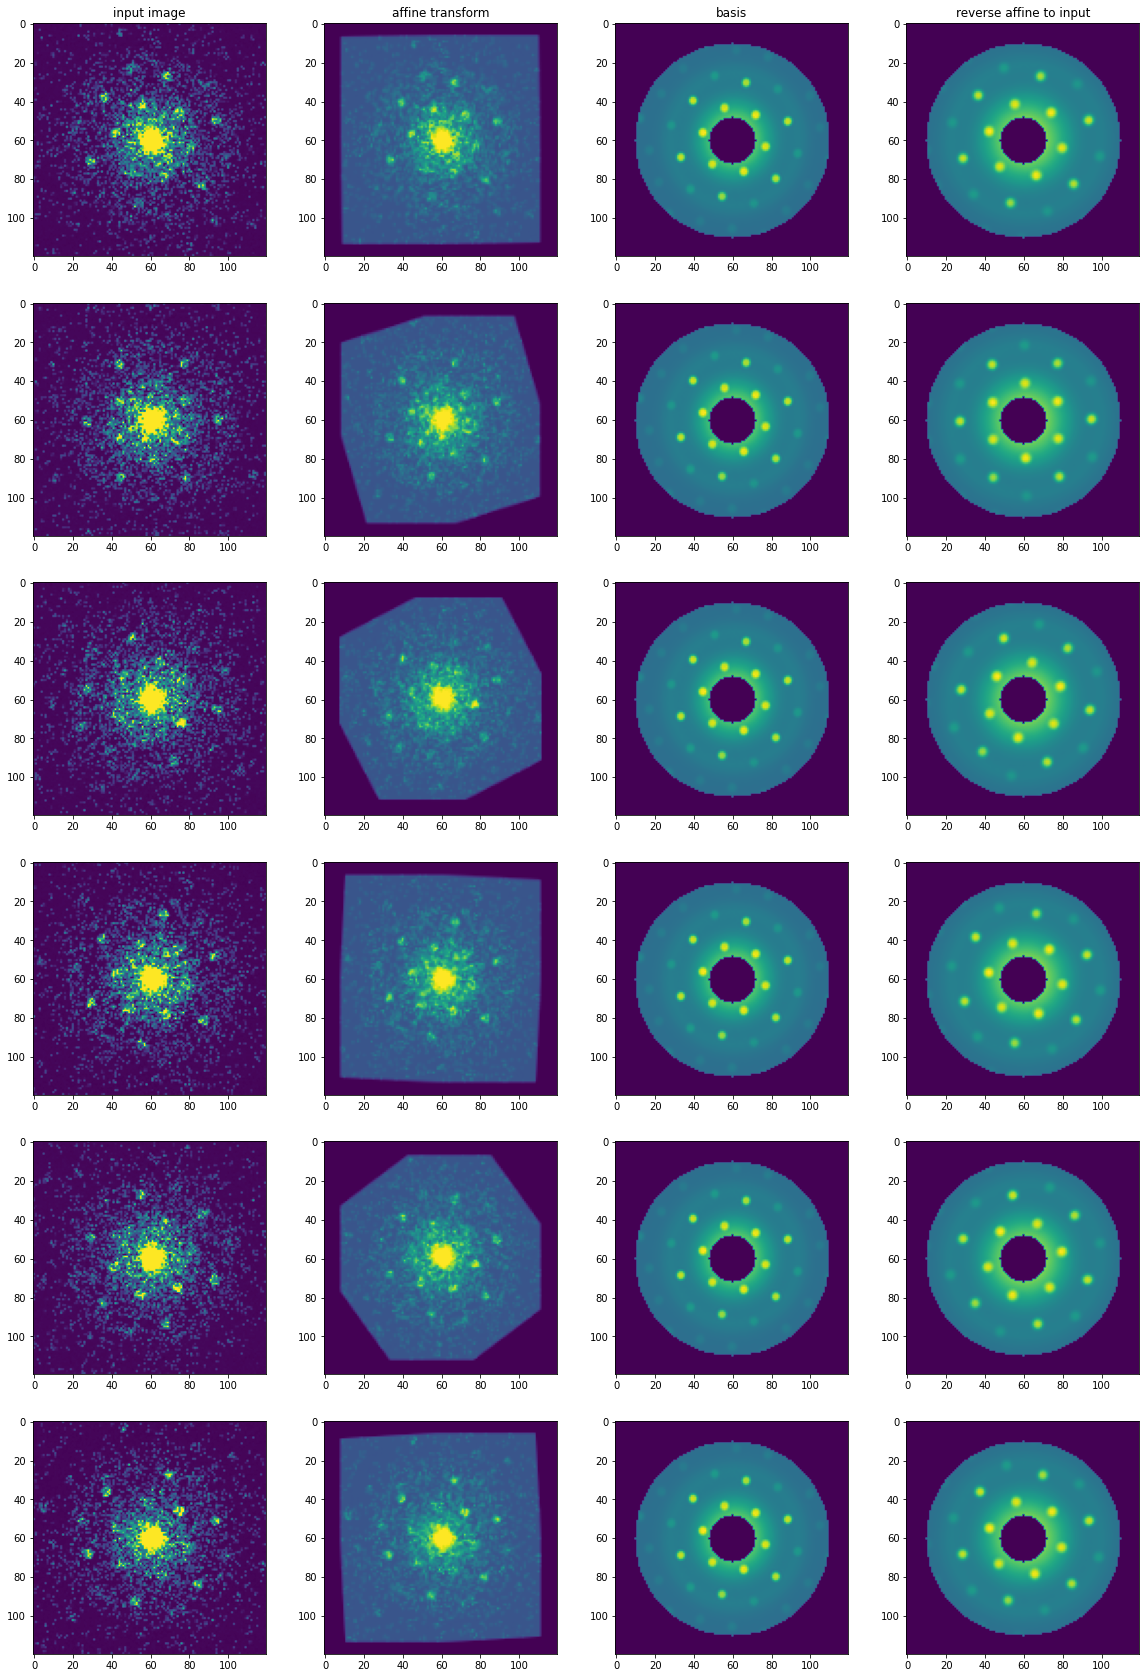

In [107]:
# Visualize the result
fig,ax = plt.subplots(6,4,figsize=(20,30))
for i in range(6):
    j = np.random.randint(0,30)
    #i = 247
    if i==0:
        ax[i][0].title.set_text('input image')
        ax[i][1].title.set_text('affine transform')
        ax[i][2].title.set_text('basis')
        ax[i][3].title.set_text('reverse affine to input')
    ax[i][0].imshow(sample[j].squeeze())
    
    ax[i][1].imshow(predicted_x[j].squeeze().detach().cpu())
    
    #ax[2].imshow((card_small.squeeze()-out[i].squeeze().detach().cpu())**2)
    #num = torch.argmax(prob[i])
    recreate_base = predicted_base[j].squeeze().detach().cpu()
    recreate_base[~new_mask]=0
    ax[i][2].imshow(recreate_base)
    
    rever_base = predicted_input[j].squeeze().detach().cpu()
    rever_base[~new_mask]=0
    ax[i][3].imshow(rever_base)
    
    #ax[3].imshow((label_[num].squeeze()-out[i].squeeze().detach().cpu())**2)
    print(kout[j])
#    print(theta_1[j])
    print(theta_1[j])
#    print(y[0][j],y[1][j])
#    print(theta[j]
    print(theta_2[j])
#plt.savefig('figures/Sampledata_4d_Wse2WS_base=2.png',format = 'png')

In [108]:
train_iterator = torch.utils.data.DataLoader(data_r_cut[0:128], batch_size = 64,shuffle = False)

In [138]:
base_8 = np.zeros([65536,2])
rotation_ = np.zeros([65536,2])
scale_ = np.zeros([65536,4])
total_loss = 0
#y0=np.zeros([11767])
#y1 = np.zeros([11767])
for i, x in enumerate(train_iterator):
    with torch.no_grad():
        value = x
        test_value = Variable(value)
        test_value = test_value.float()
        #    result,a,b,c = model(test_value)
        predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2= join(test_value.to(device, dtype=torch.float))
        
        loss = F.mse_loss(predicted_base.to('cpu').squeeze(), predicted_x.to('cpu').squeeze(), reduction='mean')\
        + F.mse_loss(predicted_input.to('cpu').squeeze(), x.to('cpu').squeeze(), reduction='mean')
        
        total_loss+=loss
        
        
        base_8[i*64:(i+1)*64] = kout.cpu().detach().numpy()
        
        rotation_[i*64:(i+1)*64] = theta_1[:,:,0].cpu().detach().numpy()
        
        scale_[i*64:(i+1)*64] = theta_2[:,:,0:2].cpu().detach().numpy().reshape(-1,4)
        #    mn,st,log,embedding = encoder(test_value)
        #     result1 = result1.reshape(784,1000,1)
#        learned[i*41:(i+1)*41,:] = theta_
#        y0[i*41:(i+1)*41] = y[0].numpy()
#        y1[i*41:(i+1)*41] = y[1].numpy()
        if i%10==0:
            print('the predict process is ...'+ format(100*i/len(train_iterator),'.2f')+ '%')
total_loss/=256
print('mse_loss'+str(total_loss))

/tmp/ipykernel_82989/573285901.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  kout = self.softmax(kout)


the predict process is ...0.00%
mse_losstensor(0.0005, dtype=torch.float64)


In [139]:
rotation_.shape, scale_.shape
# rotation_ = new_rots
# scale_ = new_scal

((65536, 2), (65536, 4))

0
1
total activated channels: 2


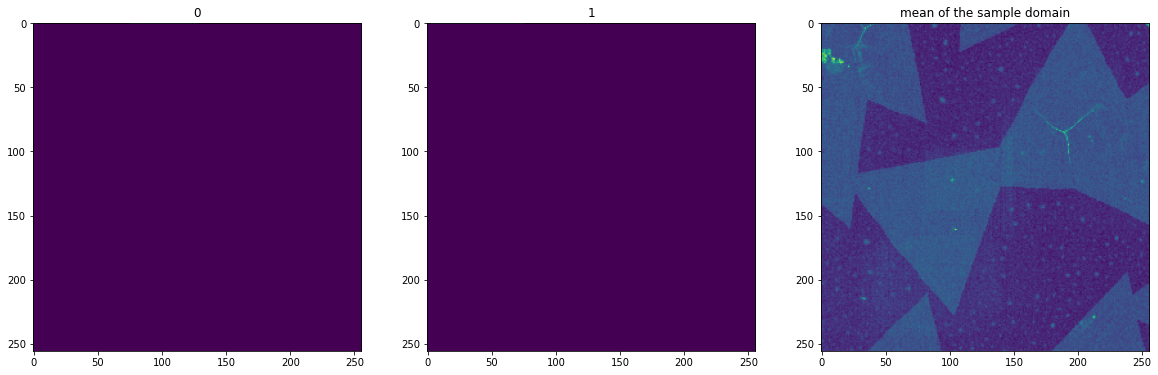

In [150]:
#base=2,loss=0.024
j=0
list_new = []
fig,ax = plt.subplots(1,3,figsize=(20,10))
for i in range(2):
#     m = int(i/3)
#     n = i%2
    if np.sum(base_8[:,i]!=0):
        j+=1
        print(i)
        list_new.append(i)
        ax[i].title.set_text(str(i))
        ax[i].imshow(base_8[:,i].reshape(256,256))
print('total activated channels: '+str(j))
ax[2].title.set_text('mean of the sample domain')
ax[2].imshow(np.mean(data_r_cut.reshape(256,256,-1),axis=2))

(array([2.9000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0590e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7790e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

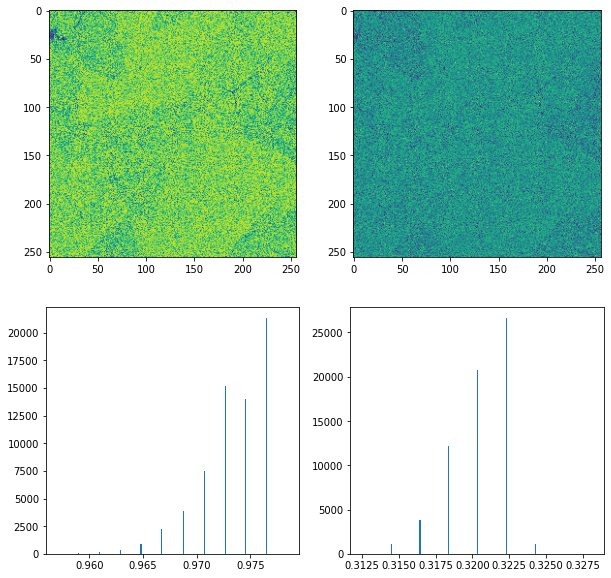

In [131]:
fig,ax = plt.subplots(2,2,figsize = (10,10))
ax[0][0].imshow(rotation_[:,0].reshape(256,256))
ax[0][1].imshow(rotation_[:,1].reshape(256,256))
ax[1][0].hist(rotation_[:,0].reshape(-1),200)
ax[1][1].hist(rotation_[:,1].reshape(-1),200)

In [132]:
sample_base = base_8[:,1].reshape(256,256)

In [133]:
scale_0 = np.multiply(sample_base.reshape(256,256),scale_[:,0].reshape(256,256))
scale_1 = np.multiply(sample_base.reshape(256,256),scale_[:,3].reshape(256,256))

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1.1    , 1.10035, 1.1007 , 1.10105, 1.1014 , 1.10175, 1.1021 ,
        1.10245, 1.1028 , 1.103

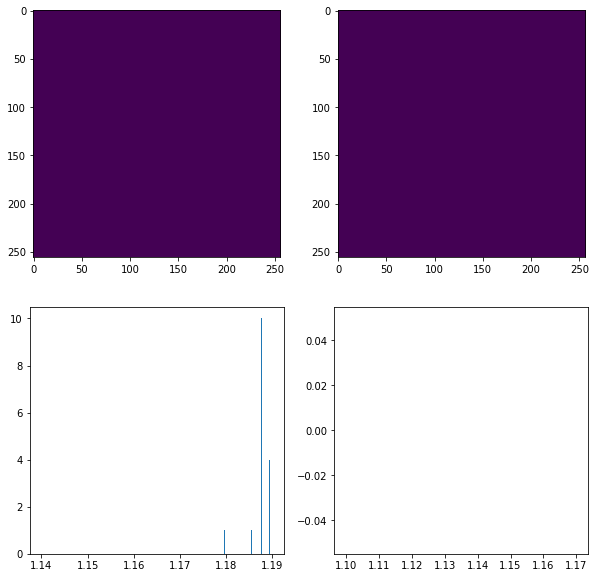

In [134]:
fig,ax = plt.subplots(2,2,figsize = (10,10))
clim0 = [1.14,1.19]
clim1 = [1.1,1.17]
ax[0][0].imshow(scale_0,clim=clim0)
ax[0][1].imshow(scale_1,clim=clim1)
ax[1][0].hist(scale_0.reshape(-1),200,range=clim0)
ax[1][1].hist(scale_1.reshape(-1),200,range=clim1)
#fig.savefig('scale_parameter.png')

In [135]:
right_tri = np.sqrt(scale_0**2+scale_1**2).reshape(256,256)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1.59  , 1.5903, 1.5906, 1.5909, 1.5912, 1.5915, 1.5918, 1.5921,
        1.5924, 1.5927, 1.593 

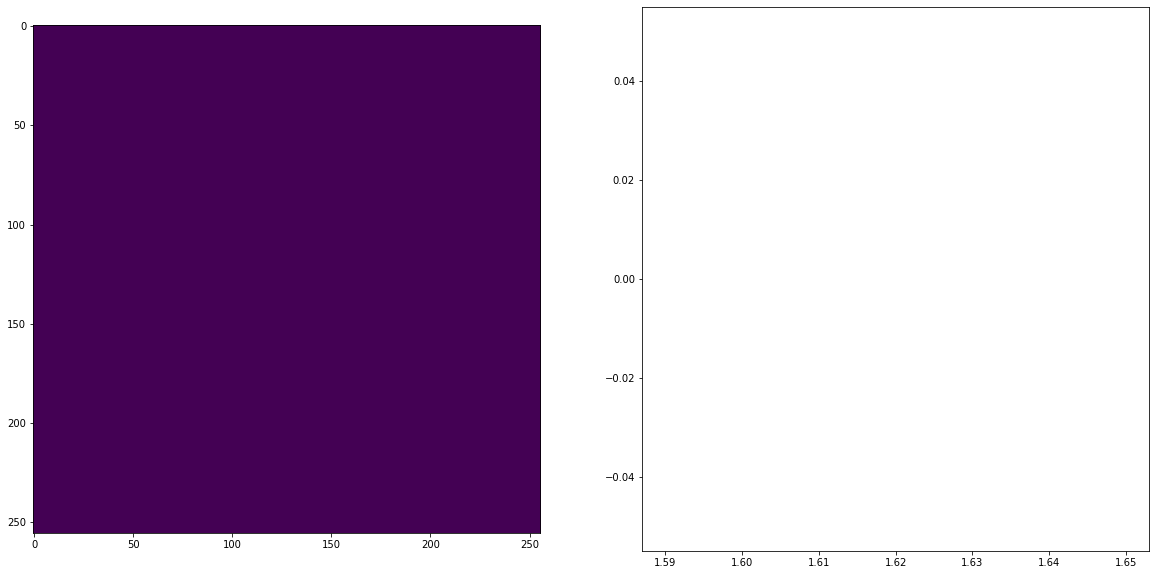

In [136]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
clim=[1.59,1.65]
ax[0].imshow(right_tri,clim=clim)
ax[1].hist(right_tri.reshape(-1),200,range=clim)

In [121]:
import keras
from sklearn.model_selection import train_test_split
from qkeras.utils import _add_supported_quantized_objects

# load float model
float_model = keras.models.load_model('models/float_model/distilled_float_model.h5')

# load quant model
co = {}
_add_supported_quantized_objects(co)
quant_model = keras.models.load_model('models/quant_model/distilled_quantized_model.h5', custom_objects=co)

# load smaller models
extra_4b = keras.models.load_model('models/extra_small_4b/model.h5', custom_objects=co)
extra_6b = keras.models.load_model('models/extra_small_6b/model.h5', custom_objects=co)
extra_8b = keras.models.load_model('models/extra_small_8b/model.h5', custom_objects=co)



from keras import backend as K
K.clear_session()

In [122]:
data_r_cut = data_r_cut.reshape(256,256,120,120)
data_r_cut = np.rot90(data_r_cut)
X = data_r_cut.reshape(-1, 120,120)

# generate outputs/targets
dataset_h5 = h5py.File('unbinned_results.h5','r+')
rots = np.array(dataset_h5['rotation'])
scal = np.array(dataset_h5['scale'])
y = np.concatenate((rots, scal), axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [123]:
float_preds = float_model.predict(X)
quant_preds = quant_model.predict(X)
extra_4b_preds = extra_4b.predict(X)
extra_6b_preds = extra_6b.predict(X)
extra_8b_preds = extra_8b.predict(X)
float_mse = np.mean((float_preds - y)**2)
quant_mse = np.mean((quant_preds - y)**2)
extra_4b_mse = np.mean((extra_4b_preds - y)**2)
extra_6b_mse = np.mean((extra_6b_preds - y)**2)
extra_8b_mse = np.mean((extra_8b_preds - y)**2)

print("Float MSE: {} \nQuant MSE: {} \Extra Small 4bMSE: {} \nQuant Extra Small 6b MSE: {} \nQuant Extra Small 8b MSE: {}".format(
    float_mse, quant_mse, extra_4b_mse, extra_6b_mse, extra_8b_mse))

2022-04-30 15:00:38.841443: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.
2022-04-30 15:01:00.349981: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.
2022-04-30 15:01:50.705826: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.


NameError: name 'extra_7b' is not defined

In [125]:
extra_8b_preds = extra_8b.predict(X)
float_mse = np.mean((float_preds - y)**2)
quant_mse = np.mean((quant_preds - y)**2)
extra_4b_mse = np.mean((extra_4b_preds - y)**2)
extra_6b_mse = np.mean((extra_6b_preds - y)**2)
extra_8b_mse = np.mean((extra_8b_preds - y)**2)


print("Float MSE: {} \nQuant MSE: {} \Extra Small 4bMSE: {} \nQuant Extra Small 6b MSE: {} \nQuant Extra Small 8b MSE: {}".format(
    float_mse, quant_mse, extra_4b_mse, extra_6b_mse, extra_8b_mse))

Float MSE: 0.012582642750694616 
Quant MSE: 0.01290803826851726 \Extra Small 4bMSE: 0.012538241283981136 
Quant Extra Small 6b MSE: 0.6427013611083346 
Quant Extra Small 8b MSE: 0.04103722803129563


In [128]:
new_rots, new_scal = extra_4b_preds[:, 0:2], extra_4b_preds[:, 2:]
new_rots.shape, new_scal.shape

((65536, 2), (65536, 4))

## hls4ml conversion

In [41]:
import hls4ml
# hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
# hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
# hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(extra_model, granularity='model')
config['Model']['ReuseFactor'] = 64
config['SkipOptimizers'] = ['reshape_stream']
config['SkipOptimizers'].append('relu_merge')
print(config)
# hls_model = hls4ml.converters.convert_from_keras_model(extra_model,
#                                                        hls_config=config,
#                                                        output_dir='quant_model/hls4ml_prj',
#                                                        part='xcu250-figd2104-2L-e')
# hls_model.compile()
# hls_model.build(csim=False)

Interpreting Model
Topology:
Layer name: input, layer type: Input
Layer name: q_conv2d_batchnorm, layer type: QConv2DBatchnorm
Layer name: q_activation, layer type: QActivation
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: q_conv2d_batchnorm_1, layer type: QConv2DBatchnorm
Layer name: q_activation_1, layer type: QActivation
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: q_conv2d_batchnorm_2, layer type: QConv2DBatchnorm
Layer name: q_activation_2, layer type: QActivation
Layer name: max_pooling2d_2, layer type: MaxPooling2D
Layer name: q_dense_batchnorm, layer type: QDenseBatchnorm
Layer name: q_activation_3, layer type: QActivation
Layer name: q_dense, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 64, 'Strategy': 'Latency'}, 'SkipOptimizers': ['reshape_stream', 'relu_merge']}


In [ ]:
from torchsummary import summary
summary(encoder, (1, 120,120))